### モジュール・データの準備

In [194]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
import lightgbm as lgb
import xgboost as xgb

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

%matplotlib inline

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

PassengerId = test['PassengerId']

### 特徴量エンジニアリング

In [195]:
# 新たな特徴量（family_size）を考える
train['FamilySize'] = train['Parch'] + train['SibSp'] + 1
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1


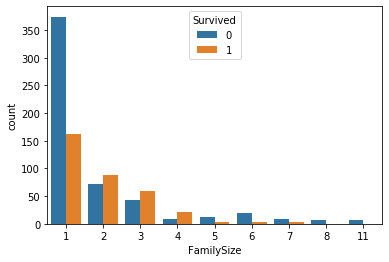

In [196]:
# 目的変数との相関性を見る
sns.countplot(x='FamilySize', data=train, hue='Survived')

In [197]:
test['FamilySize'] = test['Parch'] + test['SibSp'] + 1

In [198]:
# 新たな特徴量（1人での乗船）を考える
train['IsAlone'] = 0
train.loc[train['FamilySize'] == 1, 'IsAlone'] = 1
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,1


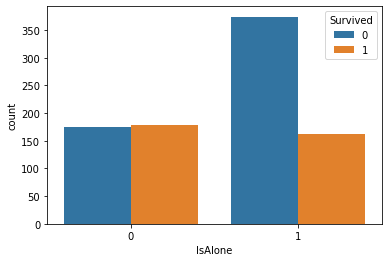

In [199]:
# 目的変数との相関性を見る
sns.countplot(x='IsAlone', data=train, hue='Survived')

In [200]:
test['IsAlone'] = 0
test.loc[test['FamilySize'] == 1, 'IsAlone'] = 1

### 前処理

In [201]:
y = train['Survived']
train = train[[col for col in train.columns if col != 'Survived']]

print('train:',train.shape)
print('test:',test.shape)

X_total = pd.concat([train, test], axis=0)

print('X_total:',X_total.shape)
print(X_total.isnull().sum())
X_total.head()

train: (891, 13)
test: (418, 13)
X_total: (1309, 13)
PassengerId       0
Pclass            0
Name              0
Sex               0
Age             263
SibSp             0
Parch             0
Ticket            0
Fare              1
Cabin          1014
Embarked          2
FamilySize        0
IsAlone           0
dtype: int64


,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,0
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,0
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,1


In [202]:
X_total.fillna(value=-999, inplace=True)

print('<After>')
print(X_total.isnull().sum())

categorical_col = [col for col in X_total.columns if X_total[col].dtype == 'object']
print('categorical_col:', categorical_col)

for i in X_total[categorical_col]:
    print('{}: {}'.format(i, X_total[i].dtype))

for i in categorical_col:
    X_total[i] = X_total[i].astype("category")
    
for i in X_total[categorical_col]:
    print('{}: {}'.format(i, X_total[i].dtype))

<After>
PassengerId    0
Pclass         0
Name           0
Sex            0
Age            0
SibSp          0
Parch          0
Ticket         0
Fare           0
Cabin          0
Embarked       0
FamilySize     0
IsAlone        0
dtype: int64
categorical_col: ['Name', 'Sex', 'Ticket', 'Cabin', 'Embarked']
Name: object
Sex: object
Ticket: object
Cabin: object
Embarked: object
Name: category
Sex: category
Ticket: category
Cabin: category
Embarked: category


In [203]:
# idなど、不要なデータは必ず抜いてから学習させる
X_total = X_total[[col for col in X_total.columns if col != 'PassengerId']]
X_total.head()

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,-999,S,2,0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,0
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,-999,S,1,1
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,0
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,-999,S,1,1


In [204]:
# category_typeなので、標準化を行ってはいけない
train_rows = train.shape[0]
X = X_total[:train_rows]

print('X:', X.shape)
print('y:', y.shape)

X: (891, 12)
y: (891,)


### 1. LightGBM（Hold-out）

In [205]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('X_test:', X_test.shape)
print('y_test:', y_test.shape)

for i in X_total.columns:
    print('{}: {}'.format(i, X[i].dtype))

X_train: (623, 12)
y_train: (623,)
X_test: (268, 12)
y_test: (268,)
Pclass: int64
Name: category
Sex: category
Age: float64
SibSp: int64
Parch: int64
Ticket: category
Fare: float64
Cabin: category
Embarked: category
FamilySize: int64
IsAlone: int64


### パラメータのチューニング

In [206]:
# 関数の作成
def objective(trial):
    params = {
        'objective': 'binary',
        'max_bin': trial.suggest_int('max_bin', 255, 500),
        'learning_rate': 0.05,
        'num_leaves': trial.suggest_int('num_leaves', 32, 128),
    }

    cls = lgb.LGBMClassifier(**params)
    cls.fit(X_train, y_train, categorical_feature = categorical_col)


    y_pred = cls.predict(X_test)
    score = log_loss(y_test, y_pred)
    return score

In [207]:
study = optuna.create_study(sampler=optuna.samplers.RandomSampler(seed=0))
study.optimize(objective, n_trials=40)

params = study.best_params
print(params)

C:\Users\Owner\anaconda3\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
[I 2020-11-19 10:29:59,873] Trial 0 finished with value: 5.28396800502855 and parameters: {'max_bin': 427, 'num_leaves': 79}. Best is trial 0 with value: 5.28396800502855.
C:\Users\Owner\anaconda3\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
[I 2020-11-19 10:30:00,153] Trial 1 finished with value: 5.28396800502855 and parameters: {'max_bin': 372, 'num_leaves': 96}. Best is trial 0 with value: 5.28396800502855.
C:\Users\Owner\anaconda3\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
[I 2020-11-19 10:30:00,443] Trial 2 finished with value: 5.28396800502855 and parameters: {'max_bin': 322, 'num_leaves': 99}. Best 

{'max_bin': 427, 'num_leaves': 79}


In [208]:
cls = lgb.LGBMClassifier(**params)
cls.fit(X_train, y_train, categorical_feature = categorical_col)

C:\Users\Owner\anaconda3\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_bin=427,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=79,
               objective=None, random_state=None, reg_alpha=0.0, reg_lambda=0.0,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0)

In [209]:
y_pred = cls.predict(X_test)
print(y_pred[:5])

y_proba = cls.predict_proba(X_test)[: , 1]
print(y_proba[:5])

[1 0 1 0 0]
[0.75556816 0.01984759 0.64526962 0.17418234 0.05878218]


### 特徴量の重要度

In [210]:
print('Feature importances:\n{}'.format(cls.feature_importances_))

Feature importances:
[ 97   0  98 855  56  44   0 967  13 109  89  16]


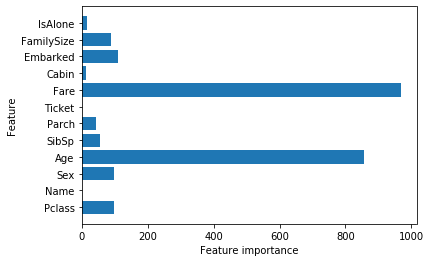

In [211]:
def plot_feature_importances_titanic(model):
    n_features = X_total.shape[1]
    feature_names = X_total.columns
    
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), feature_names)
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances_titanic(cls)

accuracy: 0.835820895522388
f1_score: 0.7755102040816326


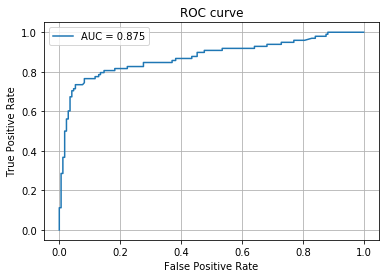

In [212]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)
plt.plot(fpr, tpr, label='AUC = %.3f' % (auc_score))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

print('accuracy:',accuracy_score(y_test, y_pred))
print('f1_score:',f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.87      0.87       170
           1       0.78      0.78      0.78        98

    accuracy                           0.84       268
   macro avg       0.82      0.82      0.82       268
weighted avg       0.84      0.84      0.84       268



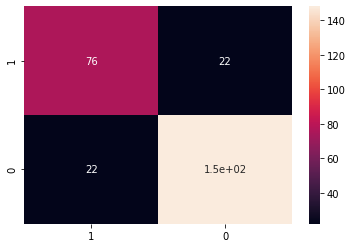

In [213]:
classes = [1, 0]
cm = confusion_matrix(y_test, y_pred, labels=classes)

cmdf = pd.DataFrame(cm, index=classes, columns=classes)

sns.heatmap(cmdf, annot=True)
print(classification_report(y_test, y_pred))

In [214]:
X_submit = X_total[train_rows:]

y_proba_submit = cls.predict_proba(X_submit)[: , 1]
y_pred_submit = cls.predict(X_submit)

lgb_hold_submit = pd.DataFrame(y_pred_submit, index=PassengerId, columns=['Survived'])
lgb_hold_submit.to_csv('titanic_lgb_hold.csv')

lgb_hold_submit.head(10)

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0
897,0
898,0
899,0
900,1


### 2. LightGBM（Cross-Validation）

In [215]:
# 5つのfold（0～4)に分割
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

y_preds = []
scores = []
models = []

In [216]:
for fold_id, (train_index, test_index) in enumerate(cv.split(X, y)):
    X_train = X.loc[train_index, :]
    X_test = X.loc[test_index, :]
    y_train = y[train_index]
    y_test = y[test_index]
    
    print('fold:',{fold_id})
    print('y_train ==1 rate:', {sum(y_train) / len(y_train)})
    print('y_test ==1 rate:', {sum(y_test) / len(y_test)})
    
    params = {"random_state": 42}

    cls = lgb.LGBMClassifier(**params)
    cls.fit(X_train, y_train, categorical_feature = categorical_col)
    
    y_pred = cls.predict(X_test)
    score = cls.score(X_test, y_test)

    y_preds.append(y_pred)
    scores.append(score)
    models.append(cls)

fold: {0}
y_train ==1 rate: {0.38342696629213485}
y_test ==1 rate: {0.3854748603351955}


C:\Users\Owner\anaconda3\lib\site-packages\lightgbm\basic.py:1551: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')


fold: {1}
y_train ==1 rate: {0.38429172510518933}
y_test ==1 rate: {0.38202247191011235}
fold: {2}
y_train ==1 rate: {0.38429172510518933}
y_test ==1 rate: {0.38202247191011235}
fold: {3}
y_train ==1 rate: {0.38429172510518933}
y_test ==1 rate: {0.38202247191011235}
fold: {4}
y_train ==1 rate: {0.38288920056100983}
y_test ==1 rate: {0.38764044943820225}


In [217]:
print(fold_id)

print(train_index.shape)
print(test_index.shape)

print(train_index[:12])
print(test_index[:2])

print(y_train[:2])
print(y_test[:2])

4
(713,)
(178,)
[ 0  3  4  5  6  7  9 10 11 12 14 15]
[1 2]
0    0
3    1
Name: Survived, dtype: int64
1    1
2    1
Name: Survived, dtype: int64


In [218]:
cv_score = sum(scores) / len(scores)

print('scores:', scores)
print('cv_score:', cv_score)

scores: [0.8212290502793296, 0.8314606741573034, 0.848314606741573, 0.7752808988764045, 0.7921348314606742]
cv_score: 0.8136840123030569


In [219]:
for i, n in enumerate(scores):
    if n == max(scores):
        model_best = models[i]
        print('No.{}:{}'.format(i, model_best))

No.2:LGBMClassifier(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               importance_type='split', learning_rate=0.1, max_depth=-1,
               min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
               n_estimators=100, n_jobs=-1, num_leaves=31, objective=None,
               random_state=42, reg_alpha=0.0, reg_lambda=0.0, silent=True,
               subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [224]:
X_submit = X_total[train_rows:]

y_proba_submit = model_best.predict_proba(X_submit)[: , 1]
y_pred_submit = model_best.predict(X_submit)

lgb_valid_submit = pd.DataFrame(y_pred_submit, index=PassengerId, columns=['Survived'])
lgb_valid_submit.to_csv('titanic_lgb_valid.csv')

lgb_valid_submit.head(10)

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0
897,0
898,1
899,0
900,1


### 3. XGBoost（Hold-out）

In [185]:
X_total = pd.concat([train, test], axis=0)
X_total.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone
0,1,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,2,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,2,0
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,1,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,2,0
4,5,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,1,1


In [186]:
def code_transform(x):
    if x == 'male':
        y = 0
    else:
        y = 1
    return y

def code_transform(x):
    if x == 'C':
        y = 0
    elif x == 'Q':
        y = 1
    else:
        y = 2
    return y

X_total['Embarked'] = X_total['Embarked'].apply(lambda x: code_transform(x))
X_total['Sex'] = X_total['Sex'].apply(lambda x: code_transform(x))

X_total.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,IsAlone
0,1,3,"Braund, Mr. Owen Harris",2,22.0,1,0,A/5 21171,7.2500,NaN,2,2,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",2,38.0,1,0,PC 17599,71.2833,C85,0,2,0
2,3,3,"Heikkinen, Miss. Laina",2,26.0,0,0,STON/O2. 3101282,7.9250,NaN,2,1,1
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",2,35.0,1,0,113803,53.1000,C123,2,2,0
4,5,3,"Allen, Mr. William Henry",2,35.0,0,0,373450,8.0500,NaN,2,1,1


In [187]:
numerical_col = [col for col in X_total.columns if X_total[col].dtype != 'object']
categorical_col = [col for col in X_total.columns if X_total[col].dtype == 'object']

X_num = X_total[numerical_col]
X_cat = X_total[categorical_col]

print('numerical_col:', numerical_col)
print('categorical_col:', categorical_col)

numerical_col: ['PassengerId', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked', 'FamilySize', 'IsAlone']
categorical_col: ['Name', 'Ticket', 'Cabin']


In [188]:
X_num.fillna(X_num.median(), inplace=True)
X_cat.fillna(value='missing', inplace=True)

X_cat = pd.get_dummies(X_cat)

X_total = pd.concat([X_num, X_cat], axis=1)
X_total = X_total[[col for col in X_total.columns if col != 'PassengerId']]

print(X_total.shape)
X_total.head()

C:\Users\Owner\anaconda3\lib\site-packages\pandas\core\generic.py:6245: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
C:\Users\Owner\anaconda3\lib\site-packages\pandas\core\frame.py:4153: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


(1309, 2432)


,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,FamilySize,IsAlone,"Name_Abbing, Mr. Anthony",...,Cabin_F E69,Cabin_F G63,Cabin_F G73,Cabin_F2,Cabin_F33,Cabin_F38,Cabin_F4,Cabin_G6,Cabin_T,Cabin_missing
0,3,2,22.0,1,0,7.2500,2,2,0,0,...,0,0,0,0,0,0,0,0,0,1
1,1,2,38.0,1,0,71.2833,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,2,26.0,0,0,7.9250,2,1,1,0,...,0,0,0,0,0,0,0,0,0,1
3,1,2,35.0,1,0,53.1000,2,2,0,0,...,0,0,0,0,0,0,0,0,0,0
4,3,2,35.0,0,0,8.0500,2,1,1,0,...,0,0,0,0,0,0,0,0,0,1


In [162]:
train_rows = train.shape[0]
X = X_total[:train_rows]

std = StandardScaler()
X = std.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=123)

In [175]:
# XGBoostは時間がかかるので、パラメータ調整はさらに時間を要する
clf = xgb.XGBClassifier(objective='binary:logistic', n_estimators=1000)
clf.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [176]:
y_pred = clf.predict(X_test)
print(y_pred[:5])

y_proba = clf.predict_proba(X_test)[: , 1]
print(y_proba[:5])

[1 0 1 0 1]
[0.98714334 0.00108903 0.93069303 0.01923724 0.6664979 ]


accuracy: 0.6716417910447762
f1_score: 0.5728155339805826


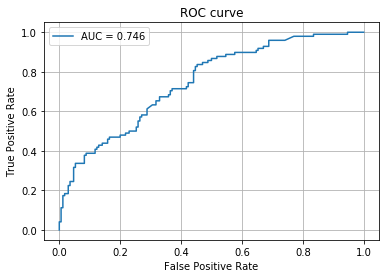

In [177]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
auc_score = roc_auc_score(y_test, y_proba)
plt.plot(fpr, tpr, label='AUC = %.3f' % (auc_score))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

print('accuracy:',accuracy_score(y_test, y_pred))
print('f1_score:',f1_score(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.76      0.71      0.73       170
           1       0.55      0.60      0.57        98

    accuracy                           0.67       268
   macro avg       0.65      0.66      0.65       268
weighted avg       0.68      0.67      0.67       268



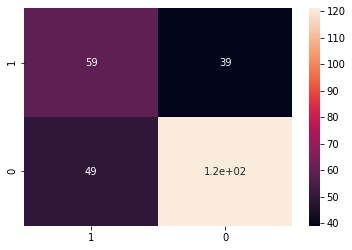

In [178]:
classes = [1, 0]
cm = confusion_matrix(y_test, y_pred, labels=classes)

cmdf = pd.DataFrame(cm, index=classes, columns=classes)

sns.heatmap(cmdf, annot=True)
print(classification_report(y_test, y_pred))

In [193]:
X_submit = X_total[train_rows:]
X_submit = std.fit_transform(X_submit)

y_proba_submit = clf.predict_proba(X_submit)[: , 1]
y_pred_submit = clf.predict(X_submit)

xgb_hold_submit = pd.DataFrame(y_pred_submit, index=PassengerId, columns=['Survived'])
xgb_hold_submit.to_csv('titanic_xgb_hold.csv')

xgb_hold_submit.head(10)

,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1
897,0
898,0
899,0
900,0


### アンサンブル学習

In [259]:
print(lgb_hold_submit.shape)
print(lgb_hold_submit['Survived'].sum())
lgb_hold_submit.head()

(418, 1)
155


,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0


In [260]:
print(lgb_valid_submit.shape)
print(lgb_valid_submit['Survived'].sum())
lgb_valid_submit.head()

(418, 1)
150


,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0


In [261]:
print(xgb_hold_submit.shape)
print(xgb_hold_submit['Survived'].sum())
xgb_hold_submit.head()

(418, 1)
147


,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1


In [271]:
sub = pd.DataFrame(lgb_hold_submit['Survived'] + lgb_valid_submit['Survived'] + xgb_hold_submit['Survived'])
print(sub['Survived'].sum())
sub

452


,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,1
...,...
1305,0
1306,3
1307,0


In [272]:
sub['Survived'] = (sub['Survived'] >= 2).astype(int)
sub.to_csv('ensemble_submit.csv')

print(sub['Survived'].sum())
sub.head(10)

# 3つ足して、全体の2/3を超えているものを1とする

148


,Survived
PassengerId,
892,0
893,0
894,0
895,0
896,0
897,0
898,0
899,0
900,1
